# 房价预测

## 获取和读取数据集

比赛数据分为训练数据集和测试数据集。两个数据集都包括每栋房子的特征，如街道类型，建造年份，房顶类型，地下室状况等特征值。这些特征值有连续的数字，离散只有训练数据集包括了每栋房子的价格，也就是标签。

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import sys 
sys.path.append("..")
import d2lzh_torch as d2l
torch.set_default_tensor_type(torch.FloatTensor)

In [2]:
train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')

In [3]:
train_data.shape,test_data.shape

((1460, 81), (1459, 80))

In [4]:
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


In [5]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

## 预先数据

我们对连续数值的特征做标准化（standardization）：设该特征在整个数据集上的均值μμ，标准差为σσ。

那么，我们可以设定特征的每个值先输入初始值。

μμ再除以σσ对于缺少的特征值，我们将其替换成该特征的均值。

In [6]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 标准化后，每个数值特征的均值变为0，所以可以直接用0来替换缺失值
all_features[numeric_features] = all_features[numeric_features].fillna(0)

接下来将离散数值转成指示特征。

举个例子，假设特征MSZoning里面有两个不同的离散值RL和RM，那么此步转换将去掉MSZoning特征，并新加两个特征MSZoning_RL和MSZoning_RM，其值为0或1。

如果一个样本原来在MSZoning里的变量RL，那么有MSZoning_RL = 1且MSZoning_RM = 0。

In [7]:
all_features = pd.get_dummies(all_features,dummy_na=True)
all_features.shape

(2919, 331)

最后，通过values属性得到NumPy格式的数据，并转成Tensor方便后面的训练。

In [8]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float)
train_labels = torch.tensor(train_data.SalePrice.values, dtype=torch.float).view(-1, 1)

## 训练模型
我们使用一个基本的线性回归模型和平方损失函数来训练模型。

In [9]:
loss = torch.nn.MSELoss()
def get_net(feature_num):
    net = nn.Linear(feature_num, 1)
    for param in net.parameters():
        nn.init.normal_(param, mean=0, std=0.01)
    return net

In [10]:
def log_rmse(net, features, labels):
    with torch.no_grad():
        # 将小于1的值设成1，使得取对数时数值更稳定
        clipped_preds = torch.max(net(features), torch.tensor(1.0))
        rmse = torch.sqrt(loss(clipped_preds.log(), labels.log()))
    return rmse.item()

下面的训练函数跟本章中前几节的不同在于使用了Adam优化算法。

相对之前使用的小批量随机梯度下降，它对学习率相对不那么敏感。

我们将在之后的“优化算法”一章里详细介绍它

In [11]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    # 这里使用了Adam优化算法
    optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate, weight_decay=weight_decay) 
    net = net.float()
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X.float()), y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

## K折交叉验证

我们在3.11节（模型选择、欠拟合和过拟合）中介绍了[Math Processing Error]K折交叉验证。

它将被用来选择模型设计并调节超参数。下面实现了一个函数，它返回第i折交叉验证时所需要的训练和验证数据

In [12]:
def get_k_fold_data(k, i, X, y):
    # 返回第i折交叉验证时所需要的训练和验证数据
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
    return X_train, y_train, X_valid, y_valid

在KK折交叉验证中我们训练KK次并返回训练和验证的平均误差。

In [13]:
def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net(X_train.shape[1])
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                         range(1, num_epochs + 1), valid_ls,
                         ['train', 'valid'])
        print('fold %d, train rmse %f, valid rmse %f' % (i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

## 模型选择
我们使用一组未经调优的超参数并计算交叉验证误差。可以改动这些超参数来尽可能减小平均测试误差。

fold 0, train rmse 0.169796, valid rmse 0.156274
fold 1, train rmse 0.162382, valid rmse 0.190423
fold 2, train rmse 0.163673, valid rmse 0.168351
fold 3, train rmse 0.168359, valid rmse 0.154729
fold 4, train rmse 0.163060, valid rmse 0.182702
5-fold validation: avg train rmse 0.165454, avg valid rmse 0.170496


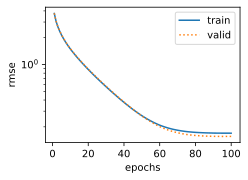

In [14]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation: avg train rmse %f, avg valid rmse %f' % (k, train_l, valid_l))

有时候你会发现一组参数的训练误差可以达到很低，但是在KK折交叉验证上的误差可能反而较高。

这种现象很可能是由过拟合造成的。因此，当训练误差降低时，我们要观察KK折交叉验证上的误差是否也相应降低。

## 预测并在Kaggle提交结果
下面定义预测函数。

在预测之前，我们会使用完整的训练数据集来重新训练模型，并将预测结果存成提交所需要的格式。

In [15]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net(train_features.shape[1])
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('./submission.csv', index=False)

train rmse 0.162359


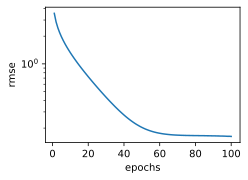

In [16]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)